# Модель прогнозирования стоимости жилья для агентства недвижимости

задача — разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import category_encoders as ce

## 1. Предварительная обработка данных

In [2]:
# загрузка данных в датафрейм
data = pd.read_csv("./data/data.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (377185, 18)


,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


### Очистка данных, дубликаты, пустые строки

In [3]:
# определяем наличие дубликатов
data_duplicated = data.duplicated()
data_duplicated.sum()

50

In [4]:
# удаляем дубликаты
data = data.drop_duplicates(ignore_index=True)
data.shape[0]

377135

In [5]:
# смотрим пропуски
data.isna().sum()

status           39917
private pool    372954
propertyType     34733
street               2
baths           106308
homeFacts            0
fireplace       274024
city                34
schools              0
sqft             40550
zipcode              0
beds             91254
state                0
stories         150674
mls-id          352193
PrivatePool     336825
MlsId            66869
target            2480
dtype: int64

Поля Mls-Id и MlsId удаляем, так как в них слишком много пропусков и они не несут полезной информации (уникальные идентификаторы)

In [6]:
# удаляем поле
data.drop(labels=['MlsId','mls-id'], axis=1, inplace=True)

### Смотрим на географию и расположение объектов

In [7]:
adres_data = data[['street', 'city', 'zipcode','state']]

In [8]:
data.loc[adres_data.duplicated()==True].head(5)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
549,For sale,NaN,Single Family,5398 Alcola Way S,2,"{'atAGlanceFacts': [{'factValue': '1971', 'fac...",Yes,Saint Petersburg,"[{'rating': ['2/10', '4/10', '4/10'], 'data': ...","1,617",33712,3,FL,1.0,Yes,"$280,000"
753,for sale,NaN,lot/land,5428 Closeburn Rd,NaN,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",NaN,Charlotte,"[{'rating': ['8/10', '7/10', '7/10'], 'data': ...","4,595 sqft",28210,5 Beds,NC,3,NaN,"$349,000"
1648,Active,NaN,Single Family Home,8 Potterville Ln,3,"{'atAGlanceFacts': [{'factValue': '2016', 'fac...",NaN,Palm Coast,"[{'rating': ['5', '4', '6', '5', 'NR', 'NR', '...",2350,32164,4,FL,One,NaN,"$279,900"
2375,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,856",85387,4,AZ,NaN,NaN,"$373,990"
2643,Active,NaN,Single Family Home,2909 Otis St NE,3.5,"{'atAGlanceFacts': [{'factValue': '1927', 'fac...",NaN,Washington,"[{'rating': ['3', '3', '3', 'NR', '5', '5', 'N...",2848,20018,4,DC,3+,NaN,"$699,000"


In [9]:
data[data['street']=='16884 W. Vereda Solana Drive']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,PrivatePool,target
236,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,025",85387,4,AZ,NaN,NaN,"$316,990"
2375,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,856",85387,4,AZ,NaN,NaN,"$373,990"
63049,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,207",85387,5,AZ,NaN,NaN,"$331,990"
92132,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,406",85387,4,AZ,NaN,NaN,"$379,990"
119233,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,958",85387,4,AZ,NaN,NaN,"$383,990"
166077,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,3,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,656",85387,4,AZ,NaN,NaN,"$366,990"
166864,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,325",85387,4,AZ,NaN,NaN,"$346,990"
219742,Active,NaN,Single Family Home,16884 W. Vereda Solana Drive,2.5,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Surprise,"[{'rating': ['5', '9', '6', '7', '7', 'NR', 'N...","2,325",85387,4,AZ,NaN,NaN,"$340,990"


В данных много записей, относящихся к одним и тем же объектам недвижимости. Вероятно они собраны из разных источников либо это повторные по времени объявления. Пока удалять их не будем, хотя есть предположение, что на качество модели это повлияет негативно

### Кодируем поля штат и город

Предварительные выводы по итогам исследования характеристик признаков:

1. Поля штат, город и зип-код явно сильно коррелирующие признаки. Оставляем один из них - зип-код.
2. Поле street необходимо удалить так как оно является идентификатором объекта недвижимости. Использование признака приведет к утечке данных.
3. Удаляем лишние поля, оставляем зип-код и кодируем его двоичным кодированием

In [10]:
data['zipcode'] = data['zipcode'].apply(lambda x: x[:5]) # обрезаем лишние символы
data['zipcode'].value_counts().count() # оцениваем метод кодирования

4318

In [11]:
# используем двоичное кодирование для признака
# zip-code
bin_encoder = ce.BinaryEncoder(cols=['zipcode'])
type_bin = bin_encoder.fit_transform(data['zipcode'])
data = pd.concat([data, type_bin], axis=1)
# удаляем исходное поле
data = data.drop(labels=['zipcode'], axis=1)
# удаляем лишние поля
data = data.drop(labels=['city','state','street'], axis=1)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377135 entries, 0 to 377134
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   baths         270827 non-null  object
 4   homeFacts     377135 non-null  object
 5   fireplace     103111 non-null  object
 6   schools       377135 non-null  object
 7   sqft          336585 non-null  object
 8   beds          285881 non-null  object
 9   stories       226461 non-null  object
 10  PrivatePool   40310 non-null   object
 11  target        374655 non-null  object
 12  zipcode_0     377135 non-null  int64 
 13  zipcode_1     377135 non-null  int64 
 14  zipcode_2     377135 non-null  int64 
 15  zipcode_3     377135 non-null  int64 
 16  zipcode_4     377135 non-null  int64 
 17  zipcode_5     377135 non-null  int64 
 18  zipcode_6     377135 non

### Распаковываем поле 'homeFacts'

In [13]:
new_features_list = list() # создаем пустой список для словарей

def homeFacts_unpack(arg): # функция распаковки поля homeFacts в словарь
    facts_dict = eval(arg)['atAGlanceFacts']
    dictionary = dict()
    for i in facts_dict:
        if i['factValue'] == '':
            dictionary[i['factLabel']] = 'none'
        else:
            dictionary[i['factLabel']] = i['factValue']
    new_features_list.append(dictionary) # добавляем словарь в список
# обрабатываем поле функцией
data['homeFacts'].apply(homeFacts_unpack)
# преобразуем список словарей в новый датафрейм
extra_data = pd.DataFrame(new_features_list)
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)

In [14]:
# получены новые признаки
extra_data.columns

Index(['Year built', 'Remodeled year', 'Heating', 'Cooling', 'Parking',
       'lotsize', 'Price/sqft'],
      dtype='object')

In [15]:
# удаляем исходное поле
data = data.drop(labels=['homeFacts'], axis=1)

Получили пять новых признаков

'Year built' - год постройки ;
'Remodeled year' - год ремонта/реновации;
'Heating' - наличие и тип отопления;
'Cooling' - наличие кондиционера;
'Parking' - паркинг;
'lotsize' - размер земельного участка;
'Price/sqft' - цена жилья за кв.фут

### Обработаем поля 'Year built' и 'Remodeled year'

In [16]:
# изучаем структуру данных в поле 
data['Year built'].value_counts().sort_index().head(10)

Year built
1       2
1019    1
1057    1
1060    1
1208    1
1700    1
1703    2
1735    1
1740    1
1750    2
Name: count, dtype: int64

In [17]:
data['Year built'].value_counts().sort_index().tail(10)

Year built
2017             5179
2018             6855
2019            32168
2020             2435
2021               62
2022                8
2025                2
559990649990        2
No Data          1222
none            58729
Name: count, dtype: int64

In [18]:
# обрабатываем странные значения Year built, пропускам присваиваем NaN
data.loc[data[data['Year built']=='1019'].index, 'Year built'] = '1919'
data.loc[data[data['Year built']=='1057'].index, 'Year built'] = '1957'
data.loc[data[data['Year built']=='1060'].index, 'Year built'] = '1960'
data.loc[data[data['Year built']=='1208'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='1'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='559990649990'].index, 'Year built'] = np.nan
#data.loc[data[data['Year built']=='no_data'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='No Data'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']=='none'].index, 'Year built'] = np.nan
data.loc[data[data['Year built']==''].index, 'Year built'] = np.nan

In [19]:
# обрабатываем странные значения в Remodeled year, пропускам присваиваем NaN
data.loc[data[data['Remodeled year']=='1111'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']==''].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='none'].index, 'Remodeled year'] = '0'
data.loc[data[data['Remodeled year']=='0'].index, 'Remodeled year'] = '0'

In [20]:
# Для пустых дат постройки Year built заполняем датой реконструкции
#data.loc[data.loc[data['Year built'].isna()].index , 'Year built'] = data['Remodeled year']
# нулевые значения года постройки меняем на nan
data.loc[data[data['Year built']=='0'].index, 'Year built'] = np.nan
#заполняем оставшиеся пропуски года постройки модой, а год реновации - 0
data = data.fillna({
    'Year built': data['Year built'].mode()[0],
    'Remodeled year': '0'
    })
# считаем пропуски
data['Year built'].isna().sum()

0

In [21]:
# Если дата постройки Year built больше даты реконструкции, то в качестве даты постройки устанавливаем дату реконструкции
# data.loc[data[data['Remodeled year'] < data['Year built']].index , 'Year built'] = data['Remodeled year']

In [22]:
# максимальное значение
data['Year built'].value_counts().sort_index().tail(5)

Year built
2019    95737
2020     2435
2021       62
2022        8
2025        2
Name: count, dtype: int64

In [23]:
# приведение поля к типу int
data['Year built'] = data['Year built'].astype('int')
data['Remodeled year'] = data['Remodeled year'].astype('int')

In [24]:
# Выполняем перекодировку полей в формат "Количество лет" с учетом максимального года = 2025
data['Year built'] = data['Year built'].apply(lambda x: 2025 - x)
data['Remodeled year'] = data['Remodeled year'].apply(lambda x: 2025-x if x > 0 else x)

In [25]:
data['Year built'].value_counts().sort_index()

Year built
0          2
3          8
4         62
5       2435
6      95737
       ...  
275        2
285        1
290        1
322        2
325        1
Name: count, Length: 222, dtype: int64

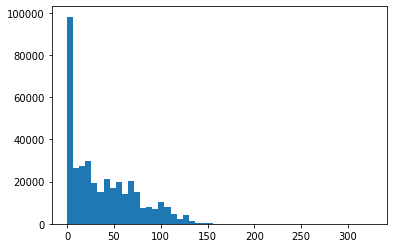

In [26]:
plt.hist(data['Year built'], bins=50);

In [27]:
data['Remodeled year'].value_counts().sort_index()

Remodeled year
0      226333
4           6
5          48
6        1473
7        1367
        ...  
172         1
179         1
180         1
225         1
287         1
Name: count, Length: 152, dtype: int64

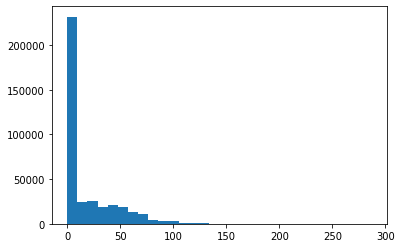

In [28]:
plt.hist(data['Remodeled year'], bins=30);

### Кодировка полей Heating, Cooling

In [29]:
# заполняем пропуски в новых признаках заглушками и приводим к упорядоченной структуре
data['Heating'] = data['Heating'].fillna('no_data')
data['Cooling'] = data['Cooling'].fillna('no_data')
data['Parking'] = data['Parking'].fillna('')
data['lotsize'] = data['lotsize'].fillna('no_data')
data['Price/sqft'] = data['Price/sqft'].fillna('no_data')
# символы переводим в нижний регистр
data['Heating'] = data['Heating'].apply(lambda x: str.lower(x))
data['Cooling'] = data['Cooling'].apply(lambda x: str.lower(x))
data['Parking'] = data['Parking'].apply(lambda x: str.lower(x))
# типизация пропусков
data['Heating'] = data['Heating'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Cooling'] = data['Cooling'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)
data['Parking'] = data['Parking'].apply(lambda x: 'no_data' if x == 'none' or x == 'other' or x == 'no data' else x)

In [30]:
data['Heating'].value_counts().head(15)

Heating
no_data                  147597
forced air               134308
electric                  10216
gas                        9296
heat pump                  8851
central air                7814
central electric           7112
central                    6247
central, electric          4253
baseboard                  3815
wall                       3301
electric heat              3064
heating system             2709
forced air, heat pump      1767
radiant                    1485
Name: count, dtype: int64

In [31]:
data['Cooling'].value_counts().head(15)

Cooling
central                                            158744
no_data                                            143774
central air                                         14384
has cooling                                          9730
central electric                                     6154
wall                                                 4017
central gas                                          3573
central heating                                      2807
cooling system                                       2700
central a/c                                          2051
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
refrigeration                                        1075
central, electric                                    1060
electric                                             1012
Name: count, dtype: int64

In [32]:
# Анализ структуры данных показывает, что сведения об отоплении и кондиционировании содержатся в обоих полях.
data['Heat_Cool'] = data['Heating'] + ' // ' + data['Cooling']
# Heating and Cooling hand-coding
data['heating_1'] = data['Heat_Cool'].apply(lambda x: 1 if 'forced air' in x else 0).astype('int')
data['heating_2'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x else 0).astype('int')
data['heating_3'] = data['Heat_Cool'].apply(lambda x: 1 if 'gas' in x else 0).astype('int')
data['heating_4'] = data['Heat_Cool'].apply(lambda x: 1 if 'central' in x 
                                            or 'heating system' in x 
                                            or 'has heating' in x else 0).astype('int')
data['heating_5'] = data['Heat_Cool'].apply(lambda x: 1 if 'radiant' in x else 0).astype('int')
data['heating_6'] = data['Heat_Cool'].apply(lambda x: 1 if 'electric' in x or 'A/C' in x or 'AC' in x else 0).astype('int')
data['heating_7'] = data['Heat_Cool'].apply(lambda x: 1 if 'baseboard' in x or 'wall' in x else 0).astype('int')
data['heating_8'] = data['Heat_Cool'].apply(lambda x: 1 if 'heat pump' in x else 0).astype('int')
data['heating_9'] = data['Heat_Cool'].apply(lambda x: 1 if 'oil' in x else 0).astype('int')
data['heating_10'] = data['Heat_Cool'].apply(lambda x: 1 if 'solar' in x else 0).astype('int')
data['heating_11'] = data['Heat_Cool'].apply(lambda x: 1 if 'zoned' in x else 0).astype('int')
#
# Cooling coding
data['cooling'] = data['Heat_Cool'].apply(lambda x: 1 if 'has cooling' in x 
                                          or 'cooling system' in x 
                                          or 'refrigeration' in x 
                                          or 'evaporative' in x 
                                          or 'window unit' in x 
                                          or 'evaporative' in x 
                                          or 'condition' in x else 0).astype('int')
#
#data['ceiling_fan'] = data['Heat_Cool'].apply(lambda x: 1 if 'ceiling fan' in x else 0).astype('int')
#data['Humidity'] = data['Heat_Cool'].apply(lambda x: 1 if 'humidity' in x else 0).astype('int')
# do we need it?
#data['heating_9'] = data['Heat_Cool'].apply(lambda x: 1 if 'heating' in x else 0)
# data['heating_0'] = data['Heating'].apply(lambda x: 1 x == 'other' or x == 'no data' or x == '' or x == np.nan)

In [33]:
# удаляем исходное поле
data = data.drop(labels=['Heating','Cooling'], axis=1)
# удаляем исходное поле
data = data.drop(labels=['Heat_Cool'], axis=1)

### Parking coding

In [34]:
# изучаем структуру
data['Parking'].value_counts().head(15)

Parking
no_data                             187548
attached garage                      70748
2 spaces                             28061
1 space                              14252
detached garage                      13200
carport                               7743
off street                            5279
3 spaces                              4724
                                      3533
carport, attached garage              3025
1                                     2936
4 spaces                              2917
2                                     2756
on street                             1707
attached garage, detached garage      1354
Name: count, dtype: int64

Применяем ручное кодирование

In [35]:
# Heating and Cooling hand-coding
for i in range(9):
    field_name = 'parking_'+str(i+1)
    data[field_name] = data['Parking'].apply(lambda x: 1 if str(i) in x else 0).astype('int')

In [36]:
# Parking features hand-coding
data['parking_10'] = data['Parking'].apply(lambda x: 1 if 'garage' in x else 0).astype('int')
data['parking_11'] = data['Parking'].apply(lambda x: 1 if 'attached' in x else 0).astype('int')
data['parking_12'] = data['Parking'].apply(lambda x: 1 if 'detached' in x else 0).astype('int')
data['parking_13'] = data['Parking'].apply(lambda x: 1 if 'carport' in x else 0).astype('int')
data['parking_14'] = data['Parking'].apply(lambda x: 1 if 'off street' in x or 'front' in x or 'slab' in x else 0).astype('int')
data['parking_15'] = data['Parking'].apply(lambda x: 1 if 'on street' in x or 'driveway' in x else 0).astype('int')
data['parking_16'] = data['Parking'].apply(lambda x: 1 if 'door opener' in x else 0).astype('int')
data['parking_17'] = data['Parking'].apply(lambda x: 1 if 'entry' in x else 0).astype('int')

In [37]:
# удаляем исходное поле
data = data.drop(labels=['Parking'], axis=1)

### Обработка и очистка поля "Lot size" (площадь земельного участка)

In [38]:
# иучаем структуру данных поля
data['lotsize']

0             no_data
1           5828 sqft
2          8,626 sqft
3          8,220 sqft
4         10,019 sqft
             ...     
377130     8,500 sqft
377131           none
377132     1,600 sqft
377133        no_data
377134     6,969 sqft
Name: lotsize, Length: 377135, dtype: object

In [39]:
# типизация данных
data['lotsize'] = data['lotsize'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('sqft lot','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres lot','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq.Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Sq. Ft.','sqft'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('—','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('--','no_data'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acre','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('acres','acre'))
data['lotsize'] = data['lotsize'].apply(lambda x: x.replace('Acres','acre'))
# проверка наличия пропусков
data['lotsize'].isna().sum()

0

In [40]:
data['lot_size'] = data['lotsize'].apply(lambda x: x.split()[0] )
data['mes_unit'] = data['lotsize'].apply(lambda x: x.split()[1] if len(x.split())>1 else 'no_data')
# удаляем исходное поле
data = data.drop(labels=['lotsize'], axis=1)

In [41]:
data['mes_unit'].value_counts()

mes_unit
sqft       163906
no_data    135939
acre        77290
Name: count, dtype: int64

In [42]:
# доп очистка данных
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace('no_data','0'))
data['lot_size'] = data['lot_size'].apply(lambda x: x.replace(',',''))
data['lot_size'] = data['lot_size'].apply(lambda x: '0' if x == '' else x)
# приведение поля к типу float
data['lot_size'] = data['lot_size'].astype('float')
# приведение площади участка к квадратным футам
data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] = data.loc[data[data['mes_unit'] == 'acre'].index, 'lot_size'] * 43560

In [43]:
data['lot_size']

0             0.0
1          5828.0
2          8626.0
3          8220.0
4         10019.0
           ...   
377130     8500.0
377131        0.0
377132     1600.0
377133        0.0
377134     6969.0
Name: lot_size, Length: 377135, dtype: float64

In [44]:
# удаляем исходное поле
data = data.drop(labels=['mes_unit'], axis=1)

### Поле 'Price/sqft'

Сильно коррелирующее с целевой переменной поле - удалить

Из этого поля можно вытащить доп.данные для определения площади дома или целевой переменной

In [45]:
# удаляем исходное поле
data = data.drop(labels=['Price/sqft'], axis=1)

### Поле target. Преобразование типа целевой переменной и очистка выбросов по целевой переменной

In [46]:
# удаляем строки с пустым полем target
data = data.dropna(axis=0, subset=['target'])
data.shape

(374655, 56)

In [47]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
specs_list = ['$',',',' ','+']

def search_for_specs(arg):
    if '/mo' in arg: # похоже на стоимость помесячной аренды, помечаем эти записи nan для последующего удаления
        arg = np.nan
        return arg
    for symbol in arg:
        if symbol in specs_list:
            arg = arg.replace(symbol,'')
    return arg
# преобразуем в тип float
data['target'] = data['target'].apply(search_for_specs).astype('float')

# удаляем новые строки с пустым target
data = data.dropna(axis=0, subset=['target'])
data.shape

(374257, 56)

In [48]:
# Удаляем строки с заведомо низкой стоимостью (<100)
data = data.drop(labels=data[data['target']<100].index, axis=0)
data.shape

(374235, 56)

In [49]:
# проверяем распределение
#fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
#histplot = sns.histplot(data = data, x = 'target', ax=axes[0])
#histplot.set_title('Price distribution')
#boxplot = sns.boxplot( data = data, x = 'target', ax = axes[1])
#boxplot.set_title('Price boxplot');

Данные загрязнены выбросами. Необходима очистка выбросов методом Тьюки

In [50]:
# Удаляем выбросы методом Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [51]:
outliers, cleaned = outliers_iqr(data, 'target')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 38106
Результирующее число записей: 336129


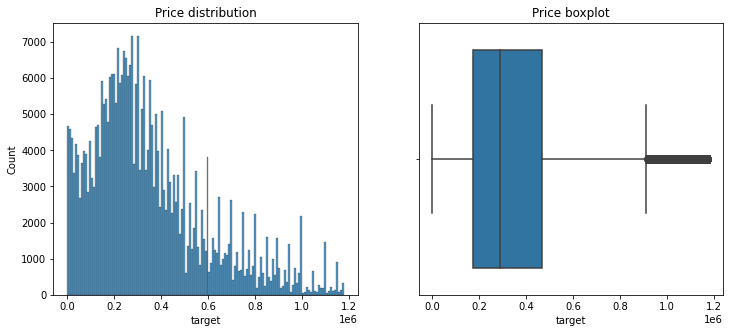

In [52]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned, x = 'target', ax=axes[0])
histplot.set_title('Price distribution')
boxplot = sns.boxplot( data = cleaned, x = 'target', ax = axes[1])
boxplot.set_title('Price boxplot');

### Один из основных признаков для расчета стоимости жилья - площадь. Выполним преобразование типа этого признака и очистку выбросов

In [53]:
# продолжаем работу с очищенными данными
data = cleaned
data['sqft']

0               2900
1         1,947 sqft
4                NaN
5           897 sqft
6              1,507
             ...    
377129         1,417
377131    2,000 sqft
377132    1,152 sqft
377133           NaN
377134         1,462
Name: sqft, Length: 336129, dtype: object

In [54]:
# удаляем новые строки с пустым sqft
data = data.dropna(subset=['sqft'], axis=0)
data.shape

(301681, 56)

In [55]:
# убираем спецсимволы
symbols_list = ['sqft','toalinerior','total','interior','livable','area',':','--',' ',',']

def search_for_symbols(arg):
    for sub_string in symbols_list:
        if sub_string in arg:
            arg = str.lower(arg).replace(sub_string,'')
    if arg == '':
        return 0
    return arg
# преобразуем в тип float
data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')

C:\Users\Ustenko-S\AppData\Local\Temp\ipykernel_16724\168637460.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sqft'] = data['sqft'].apply(search_for_symbols).astype('float')


In [56]:
# Удаляем строки со слишком малой площадью (<10)
data = data.drop(labels=data[data['sqft']<10].index, axis=0)
data.shape

(289595, 56)

In [57]:
outliers, cleaned = outliers_iqr(data, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 9696
Результирующее число записей: 279899


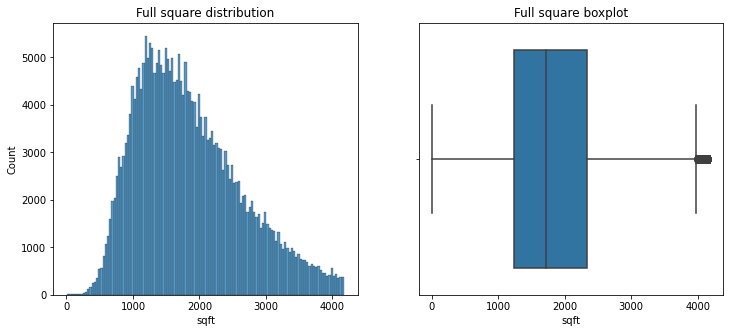

In [58]:
# проверяем распределение данных по целевой переменной
fig, axes = plt.subplots(nrows=1, ncols = 2, figsize=(12,5))
histplot = sns.histplot(data = cleaned, x = 'sqft', ax=axes[0])
histplot.set_title('Full square distribution')
boxplot = sns.boxplot( data = cleaned, x = 'sqft', ax = axes[1])
boxplot.set_title('Full square boxplot');

In [59]:
# продолжаем работу с очищенными данными
data = cleaned
data.shape

(279899, 56)

### Кодируем поле наличия бассейна

In [60]:
# изучаем структуру данных
data['PrivatePool'].value_counts()

PrivatePool
yes    21350
Yes     7956
Name: count, dtype: int64

In [61]:
# изучаем структуру данных 2-го поля
data['private pool'].value_counts()

private pool
Yes    3342
Name: count, dtype: int64

In [62]:
# определяем функцию для обработки полей
def pool_detect(arg1, arg2):
    #print(type(arg))
    if type(arg1) == str:
        if str.lower(arg1) == 'yes':
            return 1
    elif type(arg2) == str:
        if str.lower(arg2) == 'yes':
            return 1
    else:
        return 0

In [63]:
# кодируем поле по признаку наличия бассейна
data['pool'] = data[['private pool','PrivatePool']].apply(lambda x: pool_detect(*x), axis=1).astype('int')
data['pool'].value_counts()

pool
0    247251
1     32648
Name: count, dtype: int64

In [64]:
# удалим исходные поля
data = data.drop(labels=['private pool','PrivatePool'], axis=1)

### Кодируем статус

In [65]:
# изучаем значения поля статус и определяем основные признаки для кодирования
data['status'].value_counts().head(10)

status
for sale                     117163
Active                        68835
For sale                      36288
foreclosure                    5318
New construction               4622
Pending                        3930
Pre-foreclosure                1550
P                              1298
Under Contract Show             998
Pre-foreclosure / auction       959
Name: count, dtype: int64

Признаки пересекаются, необходимо применить ручное кодирование

In [66]:
data['status'].isna().sum()

31891

In [67]:
# заполняем пропуски заглушкой
data['status'] = data['status'].fillna('no_data')
# переводим текстовое поле в нижний регистр
data['status'] = data['status'].apply(lambda x: str.lower(x))

In [68]:
# унифицируем ключевые фразы
data['status'] = data['status'].apply(lambda x: 'rental' if 'for rent' in x else x)
data['status'] = data['status'].apply(lambda x: 'active' if x == 'a active' or 'coming soon' in x else x)
data['status'] = data['status'].apply(lambda x: 'reactivated' if x == 're activated' or x == 'back on market' else x)
# проверить ????
data['status'] = data['status'].apply(lambda x: 'active backup' if x == 'backup contract' or x == 'backup' or x == 'active backup' else x)
#
data['status'] = data['status'].apply(lambda x: 'active contingent' if 'active' in x and 'contingen' in x else x)
data['status'] = data['status'].apply(lambda x: 'active option' if 'active option contract' in x else x)
#
#data['status'] = data['status'].apply(lambda x: 'pending taking backups' if x == 'pending - taking backups' else x)
data['status'] = data['status'].apply(lambda x: 'contract pending' if x == 'contract p' else x)
data['status'] = data['status'].apply(lambda x: 'pending backup' if 'pending' in x and 'backup' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending contingency' if 'pending' in x and 'cont' in x else x)
data['status'] = data['status'].apply(lambda x: 'pending inspection' if x == 'p' 
                                      or x == 'pi' 
                                      or x == 'pending' 
                                      or x == 'pending in' 
                                      or x == 'pending inspection'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending continue_to_show' if x == 'ct'
                                      or ('pending' in x and 'continue' in x and 'show' in x)
                                      else x)
data['status'] = data['status'].apply(lambda x: 'pending' if x == 'pending sale'
                                      or x == 'p pending sale'
                                      or x == 'pending sh'
                                      or x == 'ps'
                                      or x == 'pf'
                                      or ('pending' in x and 'not' in x and 'show' in x)
                                      else x)

data['status'] = data['status'].apply(lambda x: 'pre-foreclosure' if x == 'pre-foreclosure / auction' else x)
data['status'] = data['status'].apply(lambda x: 'under contract' 
                                      if x == 'under contract   showing' 
                                      or x == 'under contract show' 
                                      or x == 'active under contract' 
                                      or x == 'under contract - show' 
                                      or x == 'u under contract' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'contingency' if x == 'contingent show' 
                                      or x == 'c' 
                                      or x == 'contingency 48 hr (+/ )'
                                      or x == 'contingent   release'
                                      else x)
data['status'] = data['status'].apply(lambda x: 'foreclosured' if x == 'foreclose' else x)
data['status'] = data['status'].apply(lambda x: 'auction' if x == ' / auction' 
                                      or x == 'auction - active' 
                                      or x == 'active - auction' 
                                      else x)
data['status'] = data['status'].apply(lambda x: 'new_construction' if x == 'new' or x == 'new construction' else x)

In [69]:
# 
data['status'] = data['status'].apply(lambda x: x.replace('bckp','backup').replace('back up','backup').replace('backups','backup'))
data['status'] = data['status'].apply(lambda x: x.replace('accepted','accept').replace('accpt','accept').replace('accepting','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('contingent','contingency').replace('accpt','accept'))
data['status'] = data['status'].apply(lambda x: x.replace('offers','offer').replace('financing','finance'))
data['status'] = data['status'].apply(lambda x: x.replace('  ',' ').replace(' - ',' '))

In [70]:
# Удаляем строки со статусом аренда
data = data.drop(labels=data[data['status']=='rental'].index, axis=0)
data.shape

(279894, 55)

In [71]:
# собираем словарь из ключевых фраз и кодируем поле статус по словарю
status_codes = []

def status_processing(arg):
    dict = arg.split(' ')
    for i in range(len(dict)):
        if dict[i] not in status_codes and len(dict[i])>3:
            status_codes.append(dict[i])
            
data['status'].apply(status_processing);

In [72]:
len(status_codes)

45

In [73]:
# создание новых бинарных признаков проходим циклом по списку ключевых фраз
for i in range(len(status_codes)):
    field_name = 'status_'+str(i+1)
    data[field_name] = data['status'].apply(lambda x: 1 if status_codes[i] in x else 0).astype('int')

In [74]:
data.shape

(279894, 100)

===============================================

In [75]:
# удаляем исходное поле
data = data.drop(labels=['status'], axis=1)

### Для этажности есть отдельный признак. Кодируем количество этажей с учетом данных из поля PropertyType

In [76]:
data['stories'].value_counts().head(10)

stories
1.0     62643
2.0     45912
1       21515
2       14996
3.0      8604
0.0      6081
One      5542
0        3445
3        3280
2.00     2336
Name: count, dtype: int64

In [77]:
# заполняем пропуски заглушкой
data['stories'] = data['stories'].fillna('no_data')
# символы переводим в нижний регистр
data['stories'] = data['stories'].apply(lambda x: str.lower(x))

In [78]:
# унифицируем данные
data['stories'] = data['stories'].apply(lambda x: '1st' if x=='one' or x=='one story' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='two' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='three' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='quad' else x)
data['stories'] = data['stories'].apply(lambda x: '3+st' if x=='three or more' or x=='3+' or '3+ stories' in x else x)


data['stories'] = data['stories'].apply(lambda x: '1st' if x=='1' or x[:3]=='1.0' or x=='1 story' or x=='one story' or x=='1 level' or x=='one level' or x=='one-level' else x)
data['stories'] = data['stories'].apply(lambda x: '1.5st' if x=='1.5' or x[:3]=='1.5' else x)
data['stories'] = data['stories'].apply(lambda x: '2st' if x=='2' or x[:3]=='2.0' or x=='2 story' or x=='2 stories' or x=='two story' or x=='2 level' or x=='bi-level' or x=='townhouse' else x)
data['stories'] = data['stories'].apply(lambda x: '3st' if x=='3' or x[:3]=='3.0' or x=='3 story' or x=='3 stories' or x=='three story' or x=='3 level' or x=='tri-level' or x=='t3' else x)
data['stories'] = data['stories'].apply(lambda x: '4st' if x=='4' or x[:3]=='4.0' or x=='4 story' or x=='4 stories' or x=='4 level' or x=='quad level' else x)
data['stories'] = data['stories'].apply(lambda x: '5st' if x=='5' or x[:3]=='5.0' or x=='5 story' or x=='5 level' else x)
data['stories'] = data['stories'].apply(lambda x: '6st' if x=='6' or x[:3]=='6.0' or x=='6 story' or x=='6 level' else x)
data['stories'] = data['stories'].apply(lambda x: '7st' if x=='7' or x[:3]=='7.0' or x=='7 story' or x=='7 level' else x)
data['stories'] = data['stories'].apply(lambda x: '8st' if x=='8' or x[:3]=='8.0' or x=='8 story' or x=='8 level' else x)
data['stories'] = data['stories'].apply(lambda x: '9st' if x=='9' or x[:3]=='9.0' or x=='9 story' or x=='9 level' else x)
#
data['stories'] = data['stories'].apply(lambda x: '1st/'+x if 'one' in x or '1 story' in x or '1 level' in x or 'one level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '2st/'+x if 'two' in x or '2 stories' in x or '2 story' in x or '2 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '3st/'+x if 'three' in x or '3 stories' in x or '3 level' in x else x)
data['stories'] = data['stories'].apply(lambda x: '4st/'+x if 'quad' in x or '4 stories' in x or '4 level' in x else x)
#
data['stories'] = data['stories'].apply(lambda x: '' if x=='0' or x=='0.0' else x)
data['stories'] = data['stories'].apply(lambda x: '' if x=='no_data' else x)

In [79]:
# Crop string
data['trim_stories'] = data['stories'].apply(lambda x: x[:4])

# создаем новые признаки для основных типов этажности
data['1_story'] = data['trim_stories'].apply(lambda x: 1 if '1st' in x else 0).astype('int')
data['1_h_story'] = data['trim_stories'].apply(lambda x: 1 if '1.5st' in x else 0).astype('int')
data['2_story'] = data['trim_stories'].apply(lambda x: 1 if '2st' in x else 0).astype('int')
data['3_story'] = data['trim_stories'].apply(lambda x: 1 if '3st' in x else 0).astype('int')
data['4_story'] = data['trim_stories'].apply(lambda x: 1 if '4st' in x else 0).astype('int')
# новый признак trim_stories содержит извлеченное число этажей
data['trim_stories'] = data['trim_stories'].apply(lambda x: re.sub(r'[a-zA-Z]', '', x))
data['trim_stories'] = data['trim_stories'].apply(lambda x: x.split('.')[0])
data['trim_stories'] = data['trim_stories'].apply(lambda x: x.split('/')[0])
data['trim_stories'] = data['trim_stories'].apply(lambda x: re.sub(r'[^0-9]', '', x))
data['trim_stories'] = data['trim_stories'].apply(lambda x: 0 if x == '' else int(x)).astype('int')

data['trim_stories'].value_counts().head(5)

trim_stories
0    95197
1    94612
2    68662
3    13655
9     2687
Name: count, dtype: int64

можно еще слить поля stories и propertyType так как в них много общих данных

In [80]:
# удаляем исходное поле
data = data.drop(labels=['stories'], axis=1)

### Кодируем тип недвижимости "propertyType"

In [81]:
# исследуем структуру данных поля
data['propertyType'].value_counts().head(10)

propertyType
single-family home               79327
Single Family                    52494
Single Family Home               28036
condo                            21422
Condo                            14172
townhouse                        10603
Condo/Townhome/Row Home/Co-Op     7147
Townhouse                         6376
Traditional                       5275
multi-family                      4943
Name: count, dtype: int64

Здесь также лучше подойдет ручное кодирование

In [82]:
# заполняем пропуски заглушкой
data['propertyType'] = data['propertyType'].fillna('unknown')
# символы переводим в нижний регистр
data['propertyType'] = data['propertyType'].apply(lambda x: str.lower(x))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if x == ' ' else x)

In [83]:
# типизация данных
#data['propertyType'] = data['propertyType'].apply(lambda x: 'no_data' if x == 'none' or x == 'No Data' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('one story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('1 story','1st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 stories','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('two story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bilevel','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 levels','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('tri-level','3st'))
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'tri-level' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: '3st' if x == 'less than 4 floors' else x)
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('2 story','2st'))
data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('bi-level ','split'))
#data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('split-level','2st'))

data['propertyType'] = data['propertyType'].apply(lambda x: x.replace('midcentury','mid century').replace('midcentury','mid-century'))
data['propertyType'] = data['propertyType'].apply(lambda x: 'unknown' if 'other' in x or x == 'miscellaneous' or x == 'custom' or x == '' or x == ' ' else x)

In [84]:
extra_data_status = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
status_codes = [['single','family','detached','tiny home'],
                '1st','2st','3st',
                'condo','town','tradition','craftsman','cottage','high','federal','tudor','loft','split-entry',
                'split','basement','penthouse','historic','fourplex','mid-rise','duplex','french','elevated','a-frame',
                'bungalow','coastal',
                ['flat','apartment'],
                ['mid-rise','3+ stories'],
                ['beaux arts','art deco'],
                ['mediterran','spanish'],
                ['colonial','georgian','charleston'],
                ['english','victorian'],
                ['santa barbara','tuscan'],
                ['multi','cluster'],
                ['florida','cape','key west'],
                ['contemp','modern'],
                ['ranch','farm'],
                ['coop','co-op'],
                ['mobile','carriage'],
                ['manufactur','prefab','modular']]
# создание новых бинарных признаков проходим циклом по списку ключевых фраз
for i in range(len(status_codes)):
    if type(status_codes[i])==list and len(status_codes[i]) == 2:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 3:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x or status_codes[i][1] in x or status_codes[i][2] in x else 0).astype('int')
    elif type(status_codes[i])==list and len(status_codes[i]) == 4:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i][0] in x 
                                                      or status_codes[i][1] in x 
                                                      or status_codes[i][2] in x 
                                                      or status_codes[i][3] in x else 0).astype('int')
    else:
        field_name = 'type_'+str(i+1)
        extra_data_status[field_name] = data['propertyType'].apply(lambda x: 1 if status_codes[i] in x else 0).astype('int')
# считаем количество новых признаков
len(status_codes)

40

In [85]:
# тип земля или съемная квартира - помечаем на удаление
extra_data_status['type_lot'] = data['propertyType'].apply(lambda x: 1 if 'lot' in x or 'land' in x else 0).astype('int')

In [86]:
# склеиваем датафреймы
data = pd.concat([data, extra_data_status], axis=1)

In [87]:
# удаляем исходное поле
data = data.drop(labels=['propertyType'], axis=1)

In [88]:
# Удаляем строки с типом "земельный участок"
data = data.drop(labels=data[data['type_lot']==1].index, axis=0)
data.shape

(276883, 144)

In [89]:
# удаляем исходное поле "земельный участок"
data = data.drop(labels=['type_lot'], axis=1)

### Кодируем количество спален

In [90]:
data['beds']

0              4
1         3 Beds
5         2 Beds
6            NaN
8              3
           ...  
377128         4
377129         2
377131    3 Beds
377132    3 Beds
377134         3
Name: beds, Length: 276883, dtype: object

In [91]:
data['beds'].isna().sum()

40716

In [92]:
# заполняем пропуски заглушкой - нулем.
data['beds'] = data['beds'].fillna('0')

In [93]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['beds',' ','bd','--']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if 'sqft' in str.lower(arg) or 'bath' in str.lower(arg) or 'price' in str.lower(arg):
        return 1
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['beds'] = data['beds'].apply(search_for_symbols).astype('float').astype('int')

### Кодируем количество ванных комнат

In [94]:
data['baths']

0             3.5
1         3 Baths
5             NaN
6             NaN
8               2
           ...   
377128          2
377129          3
377131    3 Baths
377132    3 Baths
377134        2.0
Name: baths, Length: 276883, dtype: object

In [95]:
# заполняем пропуски заглушкой
data['baths'] = data['baths'].fillna('0')

In [96]:
# убираем спецсимволы в поле target и помечаем для удаления строки с пометкой /mo (помесячная аренда)
words_list = ['baths',' ','bathrooms:','ba','~','+','/','sq.ft.','-','semimod','—']

def search_for_symbols(arg):
    for sub_string in words_list:
        if sub_string in str.lower(arg):
            arg = str.lower(arg).replace(sub_string,'')
    if ',' in str.lower(arg):
        arg = str.lower(arg).replace(',','.')
    if arg == '':
        return 1
    return arg

# удаляем символы и преобразуем в тип float
data['baths'] = data['baths'].apply(search_for_symbols).astype('float')
#data['baths'] = data['baths'].apply(search_for_symbols).astype('float').astype('int')

In [97]:
# приводим к целому
data['baths'] = data['baths'].astype('int')

Поле "кол-во ванных комнат" содержит странные числа. Все что больше 10 приравниваем 1

In [98]:
# заменяем странные значения на 1
data['baths'] = data['baths'].apply(lambda x: 1 if x > 10 else x)

In [99]:
data['baths'].value_counts()

baths
2     112957
3      65083
0      51581
1      23882
4      19422
5       3215
6        524
7        156
8         51
10         6
9          6
Name: count, dtype: int64

### Кодируем количество каминов

In [100]:
data['fireplace'].value_counts().head(10)

fireplace
yes               39101
Yes               16573
1                 12542
Not Applicable     1970
2                  1331
Fireplace           692
Living Room         356
Wood Burning        277
Fireplace YN        270
1 Fireplace         267
Name: count, dtype: int64

In [101]:
# заполняем пропуски заглушкой
data['fireplace'] = data['fireplace'].fillna('0')
# символы переводим в нижний регистр
data['fireplace'] = data['fireplace'].apply(lambda x: str.lower(x))

In [102]:
extra_data = pd.DataFrame()
# собираем ключевые фразы для кодирования статусов
fireplace_keys = ['gas','closet','electric','storage','extra','utility connection',
                  ['logs','wood'],
                  ['brick','masonry']]
# создание новых бинарных признаков
for i in range(len(fireplace_keys)):
    if type(fireplace_keys[i])==list and len(fireplace_keys[i]) == 2:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i][0] in x or fireplace_keys[i][1] in x else 0).astype('int')
    else:
        field_name = 'fp_'+str(i+1)
        extra_data[field_name] = data['fireplace'].apply(lambda x: 1 if fireplace_keys[i] in x else 0).astype('int')

In [103]:
# кодируем поле по количеству каминов
fireplace_yes_words = ['gas','wood','family','features','room','den','firepit']
#fireplace_no_words = ['decorative', 'n/k', 'not app', 'fireplace yn', 'electric', 'no fireplace']

def search_for_words(arg):
    if arg == 'yes' or arg == 'fireplace' or '1' in arg or 'one' in arg:
        return 1
    elif 'two' in arg or '2' in arg:
        return 2
    elif '3' in arg:
        return 3
    else:
        for word in fireplace_yes_words:
            if word in arg:
                return 1
        return 0

# 
data['fireplace'] = data['fireplace'].apply(search_for_words).astype('int')

In [104]:
# склеиваем датафреймы
data = pd.concat([data, extra_data], axis=1)

In [105]:
data.shape

(276883, 151)

### Распаковываем поле Scools

In [106]:
# перестраиваем индекс
data_reset = data.reset_index()

In [107]:
# распаковка поля schools и извлечение новых признаков
schools_list_1 = list() # создаем пустой список для словарей
schools_list_2 = list() # создаем пустой список для словарей
# создаем новый датафрейм для обработки школьных данных
extra_data = pd.DataFrame(data_reset['schools'])

def schools_unpack(arg): # функция распаковки поля schools
    schools_list_1.append(eval(arg)[0])
    schools_list_2.append(eval(arg)[0]['data'])
    
# обрабатываем поле функцией
data_reset['schools'].apply(schools_unpack);
# преобразуем списки словарей в датафреймы
extra_data_1 = pd.DataFrame(schools_list_1)
extra_data_2 = pd.DataFrame(schools_list_2)
# склеиваем датафреймы
extra_data = pd.concat([extra_data, extra_data_1], axis=1)
extra_data = pd.concat([extra_data, extra_data_2], axis=1)

In [108]:
# новые признаки
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276883 entries, 0 to 276882
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   schools   276883 non-null  object
 1   rating    276883 non-null  object
 2   data      276883 non-null  object
 3   name      276883 non-null  object
 4   Distance  276883 non-null  object
 5   Grades    276883 non-null  object
dtypes: object(6)
memory usage: 12.7+ MB


Можно посчитать количество школ в окрестности объекта, средний рейтинг школ, среднюю дистанцию по трем новым признакам

### Обработка поля schools

In [109]:
# Определяем новый признак - количество школ в округе
extra_data['school_count'] = extra_data['name'].apply(lambda x: len(x)).astype('int')

### Определяем новые признаки из расстояний до школ

In [110]:
#extra_data['Distance'] = extra_data['Distance'].apply(lambda x: re.sub(r'[a-zA-Z] ', '', x))

# функция рассчета среднего расстояния до школ
def school_distance_avg(arg):
    n = 0
    if len(arg) > 0:
        for i in arg:
            i = re.sub(r'[a-zA-Z ]', '', i)
            if i != '':
                n += float(i)
        return round(n / len(arg),1)
    else:
        return 0
    
# функция рассчета минимального расстояния до школы
def school_distance_min(arg):
    n = 999
    if len(arg) > 0:
        counter = min_number = 0
        for i in arg:
            i = re.sub(r'[a-zA-Z ]', '', i)
            if i != '' and float(i) < n:
               min_number = counter
               n = float(i)
            counter += 1
        return [min_number, n]
    else:
        return [0, 999]
# добавляем новые признаки
extra_data['school_distance_min'] = extra_data['Distance'].apply(school_distance_min) # расстояние до ближайшей школы
extra_data['school_distance_avg'] = extra_data['Distance'].apply(school_distance_avg) # среднее расстояние до школ

### "Средний рейтинг школ в округе"

In [111]:
# функция рассчета среднего рейтинга школ
def rating_processing(arg):
    if len(arg) > 0:
        for i in range(len(arg)):
            arg[i] = re.sub(r'[a-zA-Z/10]', '', arg[i])
        return arg
    else:
        return arg

extra_data['school_rating'] = extra_data['rating'].apply(rating_processing)
#extra_data['school_rating_avg'] = extra_data['rating'].apply(rating_processing).astype('int')

In [112]:
extra_data['school_rating']

0         [4, 4, 7, , 4, 7, , ]
1                      [4, , 4]
2                            []
3                    [3, 3, , ]
4             [2, 2, 4, 7, 4, ]
                  ...          
276878                [7, 6, 5]
276879                   [3, 3]
276880                 [, 5, 7]
276881                   [5, 4]
276882                [5, 4, 3]
Name: school_rating, Length: 276883, dtype: object

In [113]:
# функция рассчета среднего рейтинга школ
def rating_processing(arg):
    n = 0
    if len(arg) > 0:
        for i in arg:
#            i = re.sub(r'/10', '', i)
            i = re.sub(r'[a-zA-Z/10]', '', i)
            if i != '':
                n += int(i)
        return round(n / len(arg),1)
    else:
        return 0

extra_data['school_rating_avg'] = extra_data['rating'].apply(rating_processing)
#extra_data['school_rating_avg'] = extra_data['rating'].apply(rating_processing).astype('int')

### Рейтинг ближайшей школы

In [114]:
extra_data['school_nearest'] = extra_data['school_distance_min'].apply(lambda x: x[0])

In [115]:
extra_data['school_rating']

0         [4, 4, 7, , 4, 7, , ]
1                      [4, , 4]
2                            []
3                    [3, 3, , ]
4             [2, 2, 4, 7, 4, ]
                  ...          
276878                [7, 6, 5]
276879                   [3, 3]
276880                 [, 5, 7]
276881                   [5, 4]
276882                [5, 4, 3]
Name: school_rating, Length: 276883, dtype: object

In [116]:
def rating_nearest_school(x, y):
    if len(x)>0:
        return x[y]
    else:
        return 0


extra_data['school_rating_prx'] = extra_data.apply(lambda row: rating_nearest_school(row['school_rating'],row['school_nearest']), axis=1)

In [117]:
extra_data['school_distance_min'] = extra_data['school_distance_min'].apply(lambda x: x[1])

In [118]:
extra_data

,schools,rating,data,name,Distance,Grades,school_count,school_distance_min,school_distance_avg,school_rating,school_rating_avg,school_nearest,school_rating_prx
0,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...","[4, 4, 7, , 4, 7, , ]","{'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4...","[Southern Pines Elementary School, Southern Mi...","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]",8,2.70,5.5,"[4, 4, 7, , 4, 7, , ]",3.2,0,4
1,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","[4, , 4]","{'Distance': ['1.65mi', '1.32mi', '1.01mi'], '...","[East Valley High School&Extension, Eastvalley...","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]",3,1.01,1.3,"[4, , 4]",2.7,2,4
2,"[{'rating': [], 'data': {'Distance': [], 'Grad...",[],"{'Distance': [], 'Grades': []}",[],[],[],0,999.00,0.0,[],0.0,0,0
3,"[{'rating': ['3', '3', '1', 'NR'], 'data': {'D...","[3, 3, , ]","{'Distance': ['0.8 mi', '8.3 mi', '4.2 mi', '2...","[Palmetto Elementary School, Haines City Senio...","[0.8 mi, 8.3 mi, 4.2 mi, 2.0 mi]","[Preschool to 4, Preschool to 12, 5 to 8, 1 to...",4,0.80,3.8,"[3, 3, , ]",1.5,0,3
4,"[{'rating': ['2', '2', '4', '7', '4', 'NR'], '...","[2, 2, 4, 7, 4, ]","{'Distance': ['5.6 mi', '5.6 mi', '6.8 mi', '6...","[Roosevelt Elementary School, Lincoln Intermed...","[5.6 mi, 5.6 mi, 6.8 mi, 6.5 mi, 6.8 mi, 6.8 mi]","[PK–4, 5–6, 9–12, PK–4, 7–8, 9–12]",6,5.60,6.4,"[2, 2, 4, 7, 4, ]",3.2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276878,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...","[7, 6, 5]","{'Distance': ['0.3 mi', '2.5 mi', '2.5 mi'], '...","[South Belt Elementary School, Thompson Interm...","[0.3 mi, 2.5 mi, 2.5 mi]","[PK-4, 7-8, 9-12]",3,0.30,1.8,"[7, 6, 5]",6.0,0,7
276879,"[{'rating': ['3/10', '3/10'], 'data': {'Distan...","[3, 3]","{'Distance': ['0.4 mi', '0.1 mi'], 'Grades': [...","[Garrison Elementary School, Cardozo Education...","[0.4 mi, 0.1 mi]","[PK-5, 6-12]",2,0.10,0.2,"[3, 3]",3.0,1,3
276880,"[{'rating': ['1/10', '5/10', '7/10'], 'data': ...","[, 5, 7]","{'Distance': ['10.61mi', '1.42mi', '0.4mi'], '...","[Hope College Prep High School, Lake View High...","[10.61mi, 1.42mi, 0.4mi]","[9-12, 9-12, PK-8]",3,0.40,4.1,"[, 5, 7]",4.0,2,7
276881,"[{'rating': ['5/10', '4/10'], 'data': {'Distan...","[5, 4]","{'Distance': ['0.48mi', '0.73mi'], 'Grades': [...","[Ps 48 William Wordsworth, Jhs 8 Richard S Gro...","[0.48mi, 0.73mi]","[PK-5, 6-8]",2,0.48,0.6,"[5, 4]",4.5,0,5


In [119]:
extra_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276883 entries, 0 to 276882
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   schools              276883 non-null  object 
 1   rating               276883 non-null  object 
 2   data                 276883 non-null  object 
 3   name                 276883 non-null  object 
 4   Distance             276883 non-null  object 
 5   Grades               276883 non-null  object 
 6   school_count         276883 non-null  int32  
 7   school_distance_min  276883 non-null  float64
 8   school_distance_avg  276883 non-null  float64
 9   school_rating        276883 non-null  object 
 10  school_rating_avg    276883 non-null  float64
 11  school_nearest       276883 non-null  int64  
 12  school_rating_prx    276883 non-null  object 
dtypes: float64(3), int32(1), int64(1), object(8)
memory usage: 26.4+ MB


In [120]:
data_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276883 entries, 0 to 276882
Columns: 152 entries, index to fp_8
dtypes: float64(3), int32(131), int64(17), object(1)
memory usage: 182.7+ MB


In [121]:
# удаляем исходный столбец
data_reset.drop(labels=['schools','index'], axis=1, inplace=True)
# удаляем исходный столбец
extra_data.drop(labels=['name','rating','data','Grades','Distance','schools'], axis=1, inplace=True)

In [122]:
# удаляем исходный столбец
extra_data.drop(labels=['school_rating','school_nearest'], axis=1, inplace=True)

In [123]:
# склеиваем датафреймы
data_reset = pd.concat([data_reset, extra_data], axis=1)

In [124]:
data_reset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276883 entries, 0 to 276882
Columns: 155 entries, baths to school_rating_prx
dtypes: float64(6), int32(132), int64(16), object(1)
memory usage: 188.0+ MB


In [125]:
data_reset

,baths,fireplace,sqft,beds,target,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,...,fp_4,fp_5,fp_6,fp_7,fp_8,school_count,school_distance_min,school_distance_avg,school_rating_avg,school_rating_prx
0,3,1,2900.0,4,418000.0,0,0,0,0,0,...,0,0,0,1,0,8,2.70,5.5,3.2,4
1,3,0,1947.0,3,310000.0,0,0,0,0,0,...,0,0,0,0,0,3,1.01,1.3,2.7,4
2,0,0,897.0,2,209000.0,0,0,0,0,0,...,0,0,0,0,0,0,999.00,0.0,0.0,0
3,0,0,1507.0,0,181500.0,0,0,0,0,0,...,0,0,0,0,0,4,0.80,3.8,1.5,3
4,2,0,3588.0,3,244900.0,0,0,0,0,0,...,0,0,0,0,0,6,5.60,6.4,3.2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276878,2,0,1841.0,4,252990.0,0,1,0,0,1,...,0,0,0,0,0,3,0.30,1.8,6.0,7
276879,3,0,1417.0,2,799000.0,0,0,0,1,1,...,0,0,0,0,0,2,0.10,0.2,3.0,3
276880,3,0,2000.0,3,674999.0,0,0,0,0,1,...,0,0,0,0,0,3,0.40,4.1,4.0,7
276881,3,0,1152.0,3,528000.0,0,0,0,0,1,...,0,0,0,0,0,2,0.48,0.6,4.5,5


In [126]:
# загрузка данных в датафрейм
data_reset.to_csv("./data/data_prepared.csv", sep=',', index=False)

In [127]:
# загрузка данных в датафрейм
df = pd.read_csv("./data/data_prepared.csv")
print('Data shape: {}'.format(df.shape))
df.head(5)

Data shape: (276883, 155)


,baths,fireplace,sqft,beds,target,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,...,fp_4,fp_5,fp_6,fp_7,fp_8,school_count,school_distance_min,school_distance_avg,school_rating_avg,school_rating_prx
0,3,1,2900.0,4,418000.0,0,0,0,0,0,...,0,0,0,1,0,8,2.70,5.5,3.2,4.0
1,3,0,1947.0,3,310000.0,0,0,0,0,0,...,0,0,0,0,0,3,1.01,1.3,2.7,4.0
2,0,0,897.0,2,209000.0,0,0,0,0,0,...,0,0,0,0,0,0,999.00,0.0,0.0,0.0
3,0,0,1507.0,0,181500.0,0,0,0,0,0,...,0,0,0,0,0,4,0.80,3.8,1.5,3.0
4,2,0,3588.0,3,244900.0,0,0,0,0,0,...,0,0,0,0,0,6,5.60,6.4,3.2,2.0
